#Neural style transfer (Нейронный перенос стиля)

## Введение
Алгоритм *Neural Style Transfer* (*NST*), разработанный Леоном Гатисом, Александром Экером и Матиасом Бетге, преобразует полученное на вход изображение в соответствии с выбранным стилем. Алгоритм берет два изображения:

Изображение контента (*Content Image*), в котором нас интересует содержание. Обычно оно является фотографией.
Изображение стиля (*Style Image*), в котором нас интересует художественный стиль (цветовое наполнение, текстуры и т.д.). Часто изображением стиля являются картины известных художников.
Затем алгоритм изменяет входные данные так, чтобы они соответствовали содержанию изображения контента и художественному стилю изображения стиля. Авторами в качестве модели сверточной нейронной сети предлагается использовать сеть *VGG16*.

## Принцип работы алгоритма NST



Рисунок 1 - Процесс передачи стиля на основе CNN. Сплошные линии показывают направление прямого распространения, а пунктирные линии показывают обратное распространение

  Сначала мы инициализируем синтезированное изображение, например, в изображение содержимого. Это синтезированное изображение является единственным параметром модели, подлежащим обновлению во время обучения. Затем мы выбираем предварительно обученную *CNN* для извлечения признаков изображения и замораживания параметров ее модели во время обучения. *CNN* использует несколько слоев для извлечения иерархических признаков изображений. Мы можем выбрать вывод некоторых из этих слоев в качестве элементов содержимого или элементов стиля. Предварительно обученная нейронная сеть, показанная на рисунке 1, имеет 3 сверточных слоя, где второй слой выводит функции контента, а первый и третий слои выводят функции стиля.
  Затем мы вычисляем функцию потерь передачи стиля посредством прямого распространения (сплошные линии) и обновляем параметры модели (синтезированное изображение для вывода) посредством обратного распространения (пунктирные линии). Функция потерь, обычно используемая при переносе стиля, состоит из трех частей: 
  - лосс контента делает синтезированное изображение и изображение контента близкими по характеристикам контента; 
  - лосс стиля делает синтезированный образ и образ стиля близкими по стилевым признакам; 
  - полный лосс вариации помогает уменьшить шум в синтезированном изображении. Наконец, когда обучение модели закончено, мы выводим параметры модели передачи стиля для создания окончательного синтезированного изображения.

In [24]:
# include the necessary libraries
import torch
import torchvision
from torch import nn
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from collections import OrderedDict
from functools import partial
from random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import re

## Изображения стиля и контента

Посмотрим на пример изображения контента и стилевого изображения.

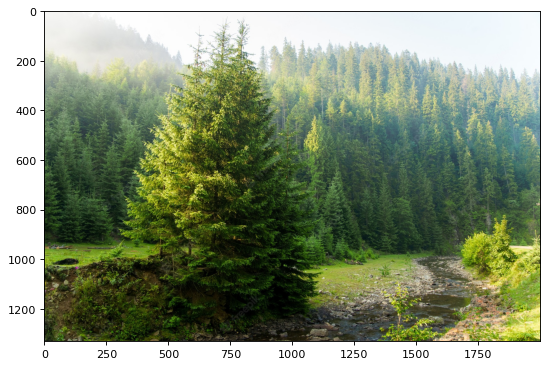

In [5]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)
content_img = cv2.imread('/kaggle/input/imageforphotostyle/forest.jpg')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
plt.imshow(content_img);

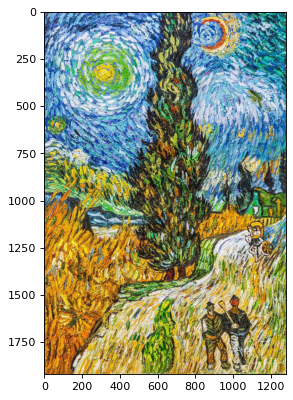

In [6]:
figure(figsize=(8,6), dpi=80)

style_img = cv2.imread('/kaggle/input/imageforphotostyle/style9.jpg')
style_img = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)
plt.imshow(style_img);

In [4]:
style_img.shape

(1431, 1920, 3)

In [5]:
content_img.shape

(1080, 864, 3)

In [7]:
image_shape = (300, 450)
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

In [8]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])

In [9]:
im = Image.fromarray(content_img)

In [10]:
transforms(Image.fromarray(content_img)).unsqueeze(0)

tensor([[[[ 2.1119,  2.1119,  2.0948,  ...,  1.9920,  2.0092,  1.9920],
          [ 2.1119,  2.0948,  2.0948,  ...,  2.0092,  2.0092,  2.0092],
          [ 2.1119,  2.1119,  2.0948,  ...,  2.0263,  2.0092,  2.0092],
          ...,
          [-0.6281, -1.0390, -1.1589,  ...,  1.5982,  1.9407,  1.8722],
          [-0.5082, -0.9020, -1.2617,  ...,  0.0912,  0.4851,  0.6906],
          [-0.7822, -1.3473, -1.6384,  ..., -0.5253, -0.6452, -0.4054]],

         [[ 2.2885,  2.2885,  2.2710,  ...,  2.3060,  2.3060,  2.2885],
          [ 2.2885,  2.2710,  2.2710,  ...,  2.3235,  2.3060,  2.3060],
          [ 2.2885,  2.2885,  2.2710,  ...,  2.3410,  2.3060,  2.3060],
          ...,
          [-0.1975, -0.6352, -0.7577,  ...,  1.7808,  1.9034,  1.8859],
          [-0.0749, -0.5126, -0.9153,  ...,  0.4503,  0.6779,  0.8004],
          [-0.4601, -1.0903, -1.4055,  ...,  0.0126,  0.0301,  0.2752]],

         [[ 2.5006,  2.4831,  2.4483,  ...,  2.5703,  2.6051,  2.6051],
          [ 2.5006,  2.4657,  

Видно, что изображения имеют разные размеры. Определим функции для обработки изображений.

In [11]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    '''preprocess standardizes each of the three RGB channels of 
    the input image and converts the results to the input CNN format
    image,image_shape get
    image return'''
    
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(Image.fromarray(img)).unsqueeze(0)

def postprocess(img):
    '''restores the pixel values in the output image to their original 
    pre-standardization values
    image get
    image return'''
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

Для извлечения признаков будем использовать сеть *VGG-19*, обученную на *ImageNet* ([Image Style Transfer Using Convolutional Neural Networks](https://ieeexplore.ieee.org/document/7780634)).

In [12]:
vgg19_pretrained = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
#r = vgg19_pretrained._save_to_state_dict()
torch.save(vgg19_pretrained, r"C:\Users\raisa\Projects\telegram_bot\image_style_changing_tel_bot\models\full_vgg19_pr.pth")

In [32]:
vgg19 = torch.load('/kaggle/working/full_vgg19_pr.pth')
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Выберем последний сверточный слой четвертого сверточного блока в качестве слоя содержимого, а первый сверточный слой каждого сверточного блока — в качестве слоя стиля ([Intuitive Guide to Neural Style Transfer](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee)). Индексы этих слоев можно получить, распечатав pretrained_net экземпляр.

In [35]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

Создадим новый экземпляр сети net, который сохранит только все слои VGG, которые будут использоваться для извлечения признаков.

In [36]:
net = nn.Sequential(*[vgg19.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [37]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [38]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [39]:
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

In [40]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [41]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [42]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip( 
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [43]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [44]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

Обучение

In [45]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    history = []
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        history.append((float(sum(contents_l)), float(sum(styles_l)), float(tv_l)))

    return X, history

In [46]:

num_epochs = 500
image_shape = (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output, history = train(content_X, contents_Y, styles_Y, device, 0.1, num_epochs, 50)

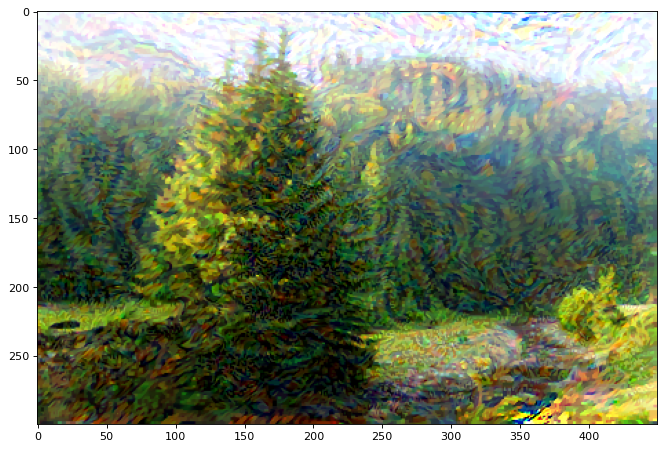

In [48]:
figure(figsize=(10,13), dpi=80)

#im = Image.fromarray(output)
plt.imshow(postprocess(output));

In [55]:
im = np.asarray(postprocess(output))

In [56]:
cv2.imwrite('output_image.jpg', im)

True

In [49]:
contents_l, styles_l, tv_l = zip(*history)

In [50]:
plt.figure(figsize=(15, 9))
plt.plot(contents_l, label="contents_l")
plt.plot(styles_l, label="styles_l")
plt.plot(tv_l, label="tv_l")
plt.xlim(10, num_epochs)
plt.legend(['content', 'style', 'TV'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [57]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)
content_img = cv2.imread('/kaggle/working/output_image.jpg')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
plt.imshow(content_img);